# GPN Cup 2021
## Кирилл Захаров

#### Импорт библиотек

In [141]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from gensim.models import Word2Vec

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

#### Импорт транзакций

In [2]:
transactions = pd.read_parquet('transactions.parquet')

In [3]:
transactions.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634.0,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900.0,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691.0,58,2171-07-23


In [4]:
len(transactions['client_id'].unique()) #Количество уникальных покупателей

370083

In [5]:
len(transactions['sku_id'].unique()) #Количество уникальных продуктов, которые покупали

4873

In [6]:
transactions.shape

(7620119, 8)

In [7]:
products_with_a = transactions.loc[np.where((transactions['number']!= 0.0) & (transactions['litrs']!= 0.0))]['sku_id']

In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620119 entries, 0 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  float64       
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 465.1 MB


#### Посмотрим есть ли данные типа None

In [9]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id     True
shop_id      False
date         False
dtype: bool

In [10]:
indx = np.where(transactions['client_id'].isna())[0]

Поскольку пустые данные содержатся в столбце клиентов, а их тип данных float64, то заменим None на нули.

In [11]:
transactions['client_id'] = transactions['client_id'].replace(np.nan, 0) 

In [12]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id    False
shop_id      False
date         False
dtype: bool

#### Импорт таблицы с номенклатурой

In [13]:
nomenclature = pd.read_parquet('nomenclature.parquet')

In [14]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


#### Посмотрим на неизвестные данные

In [15]:
nomenclature['full_name'].value_counts() #для неизвестных данных используется unknown

unknown                                                                       1370
Салфетки Novita влажные make up мицелярная вода 15шт                             1
Салфетки AROMA TOP LINE влажные парфюмированные №6 J`adore 30шт                  1
Чипсы Яблоков натуральные сладкие яблоки 25г                                     1
Зажигалка Zenga ZT-50 Torch Jet                                                  1
                                                                              ... 
Напиток Fly Cafe молокосодержащий кофейный Латте 0,3л                            1
Автопарфюм Meilleur new line 5 флакон 5мл                                        1
Жидкость охлаждающая FELIX prolonger professional антифриз зеленый -40 1кг       1
Испаритель Logic Compact электронный серый графит                                1
Резинка жевательная Orbit белоснежный классический 13,6г                         1
Name: full_name, Length: 3725, dtype: int64

В дальнейшим неизвестные товары нам не понадобятся, поэтому удалим их, для этого сначал поменяем их на None.

In [16]:
nomenclature['full_name'] = nomenclature['full_name'].replace('unknown', None)

In [17]:
nomenclature.isna().sum()

sku_id          0
full_name    1379
brand           9
sku_group       0
OTM             9
units           9
country         9
dtype: int64

In [18]:
nomenclature = nomenclature.dropna()
nomenclature.isna().sum()

sku_id       0
full_name    0
brand        0
sku_group    0
OTM          0
units        0
country      0
dtype: int64

In [19]:
nomenclature.shape

(3724, 7)

#### Объединим таблицы в одну. Для каждого значения таблицы transactions добавим описание товара из таблицы nomenclature, для это замержим по ключам слева.

In [20]:
data = pd.merge(transactions, nomenclature, how='left', on=['sku_id'])
data.dropna(inplace=True)

In [21]:
data.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,Нет,шт,РОССИЯ
11,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
12,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
13,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ


In [22]:
data = data.drop('date', axis=1) #удаление даты

#### Группы товаров для рекомендаций

In [23]:
groups = ['вода', 'Сладкие Уранированные напитки, холодный чай', 'Кофейные напитки с молоком', \
          'Энергетические напитки', 'Снеки', 'Соки и сокосодержащие напитки']

In [24]:
data[data['sku_group'].isin(groups)].head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
38,199,0.011237,0.000452,2429861,0.104183,2937.0,78,Напиток Red Bull energy drink энергетический ж...,Red Bull,Энергетические напитки,Нет,л,АВСТРИЯ
46,3328,0.007132,0.000452,2108067,0.104183,128895.0,21,"Кофе Fly Cafe Моккачино 0,4л",Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
263,3334,0.010210,0.000452,732608,0.104183,0.0,42,"Кофе Fly Cafe Латте холодный 0,2л",Fly Cafe,Кофейные напитки с молоком,Нет,л,unknown
354,407,0.005080,0.000452,3338387,0.104183,237410.0,102,Напиток Interkvass Kombucha классический стекл...,unknown,"Сладкие Уранированные напитки, холодный чай",Нет,л,РОССИЯ
444,2194,0.006619,0.000452,2345328,0.104183,225982.0,40,"Напиток Mountain DEW Уранированный ПЭТ 0,5л",Mountain DEW,"Сладкие Уранированные напитки, холодный чай",Нет,л,unknown


# Рекомендательная система

In [25]:
data['sku_id'] = data['sku_id'].astype(str) #поменяем тип данных товара на строчные для дальнейшей работы

In [26]:
customers = data['client_id'].unique().tolist() #создаем список с уникальными клиентами
len(customers)

351392

In [28]:
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

In [30]:
len(customers_train)

316253

#### Формируем обучающую выборку

In [32]:
X_train, X_test = train_test_split(data, test_size=0.1, shuffle=True, random_state=5)

In [33]:
X_train.head(2)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
1616917,3336,0.010210,0.000452,1488308,0.104183,369222.0,7,Напиток Fly Cafe молокосодержащий кофейный Мок...,Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
4358752,2637,0.008979,0.000452,650541,0.104183,268010.0,89,Сигареты PARLIAMENT platinum blue,PARLIAMENT,Табачные изделия,Нет,шт,unknown


In [38]:
customers_train = X_train['client_id'].drop_duplicates().values

#### Создадим массив истории покупок определенного товара для каждого клиента

In [40]:
purchases_train = list(X_train.groupby('client_id')['sku_id'].apply(list).to_dict().values())

In [160]:
# purchases_train_keys = list(X_train.groupby('client_id')['client_id'].apply(list).to_dict().keys())

In [42]:
purchases_train[1:4]

[['810', '218'],
 ['997', '2467', '2468', '3361'],
 ['3085', '254', '3324', '254']]

In [172]:
clients_keys = X_train['client_id'].value_counts().index.values

#### Построим модель Word2Vec для товаров.
В рамках данной модели на вход подается корпус слов, в нашем случае покупки клиентов. Затем модель создает словарь корпуса и вычисляет векторное представление слов. Таким образом на выходе мы получаем закодированные слова в виде векторов, между которыми будем далее измерять косинусное расстояние.

        1) window = 5            - ширина окна, т.е. максиальное расстояние от текущего до предсказанного слова 
                                    (эксперименты показали, что здесь лучше подходит число 5)
                                    
        2) sg = 1                - алгоритм обучения skip-gram (метод обратный CBOW, работает немного быстрее)
        
        3) hs = 0, negative = 15 - использование подхода отрицательной выборки. Идея в том, что будут изменяться не все веса, а
                                    только некоторые, тем самым происходит ускорение обучения
                                    
        4) alpha = 0.02          - начальная скорость обучения
        
        5) min_alpha = 0.0005    - минимальная скорость обучения до которой алгоритм опуститься
        
        6) seed = 5              - фиксированный seed для генерации случайных чисел
        
        7) epochs = 10           - число итераций по всему корпусу

In [43]:
# train word2vec model
model = Word2Vec(window = 5, sg = 1, hs = 0, negative = 15,
                 alpha = 0.02, min_alpha = 0.0005, seed = 5, epochs=10)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(16640259, 48351970)

In [44]:
# сохраним модель
model.save("word2vec_2.model")

In [45]:
# возьмем все вектора из корпуса
X = model.wv[model.wv.index_to_key]

X.shape

(3106, 100)

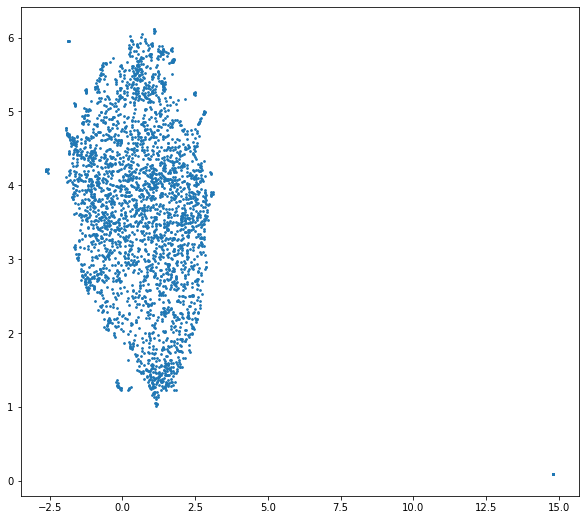

In [46]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.subplots(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

plt.show()

#### Создание словаря товаров и их характеристик

In [47]:
# создадим датафрейм с интересующими нас признаками
products = X_train[['sku_id', 'sku_group', 'price', 'brand', 'full_name']]
products = products.copy()

# удаляем повторяющиеся товары
products.drop_duplicates(inplace=True, subset='sku_id', keep="last")

# создаем словарь продуктов с названиями товаров, брендом, ценой и группой товара
groups_dict = products.groupby('sku_id')['sku_group'].apply(list).to_dict()
price_dict = products.groupby('sku_id')['price'].apply(list).to_dict()
name_dict = products.groupby('sku_id')['full_name'].apply(list).to_dict()
brand_dict = products.groupby('sku_id')['brand'].apply(list).to_dict()
sku_dict = products.groupby('sku_id')['sku_id'].apply(list).to_dict()

In [48]:
# Объединение в один словарь
keys = groups_dict.keys()
values = zip(sku_dict.values(), groups_dict.values(), price_dict.values(),\
             name_dict.values(), brand_dict.values())

In [49]:
products_dict = dict(zip(keys, values))

In [50]:
model.wv.similar_by_vector('1913', topn = len(products))[1:];

#### Функция для поиска похожих товаров
На вход подается вектор из словаря модели и число требуемых рекомендаций. Сначала отбираем все вектора, но уже упорядоченные по схожести, затем отбираем 20 лучших, которые принадлежат необходимым группам товаров.

In [51]:
def similar_products(v, n = 20):
    similar_products = model.wv.similar_by_vector(v, topn = len(products))[1:]
    
    recommend = [] #здесь будут храниться рекомендации
    k = 0 # счетчик для отбора только 20 лучших
    
    for i, product in enumerate(similar_products):
        if products_dict[product[0]][1][0] in groups and k != 20:
            recommend.append((products_dict[product[0]][0][0], products_dict[product[0]][3][0],\
                    products_dict[product[0]][1][0], products_dict[product[0]][4][0], \
                    products_dict[product[0]][2][0], product[1], k+1))
            k += 1
    return recommend

In [52]:
recommendations = similar_products(model.wv['1913'])

In [53]:
pd.DataFrame(recommendations, columns = ['sku_id', 'full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,790,"Батончик Здоровый перекус мюсли орехи,мед 55г",Снеки,unknown,0.002771,0.494824,1
1,3863,"Нектар Теди морковь ст 0,33л",Соки и сокосодержащие напитки,Теди,0.005080,0.469764,2
2,4823,"Напиток Adrenaline rush энергетический ж/б 0,25л",Энергетические напитки,Adrenaline rush,0.005080,0.444811,3
3,978,Арахис Nic Nac's хрустящая оболочка приправа 125г,Снеки,Nic Nac's,0.003848,0.442757,4
4,2324,Напиток FuzeTea безалкогольный неУранированный...,"Сладкие Уранированные напитки, холодный чай",FuzeTea,0.003540,0.439184,5
5,1533,Напиток Red Bull sugarfree энергетический ж/б ...,Энергетические напитки,Red Bull,0.005080,0.430377,6
6,286,"Квас Очаковский ПЭТ 0,4л","Сладкие Уранированные напитки, холодный чай",Очаковский,0.006619,0.428524,7
7,3271,Квас НИКОЛА традиционный ПЭТ 1л,"Сладкие Уранированные напитки, холодный чай",Никола,0.010005,0.428478,8
8,1393,Чипсы Slang кокосовые сахарный тросник 30г,Снеки,unknown,0.004053,0.423661,9
9,3039,Напиток G-Fly (СТМ) Football Edition энергетич...,Энергетические напитки,G-Fly (СТМ),0.006414,0.420863,10


In [54]:
len(recommendations)

20

#### Использование истории покупок клиента

In [55]:
def history_aggregation(client_products):
    model_product = []
    
    for product in client_products:
        try:
            model_product.append(model.wv[product])
            
        except KeyError:
            continue
        
    return np.mean(model_product, axis=0)

In [208]:
def client_history_fun(client):
    temp = np.where(clients_keys == client)[0]

    if list(temp) == []:
        return purchases_train[np.where(clients_keys == 0.0)[0][0]]
    else: 
        return purchases_train[temp[0]]

In [209]:
client_history = client_history_fun(103560.0)

In [210]:
recommendationsH = similar_products(history_aggregation(client_history)); #by client history

In [211]:
pd.DataFrame(recommendationsH, columns = ['sku_id','full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,790,"Батончик Здоровый перекус мюсли орехи,мед 55г",Снеки,unknown,0.002771,0.624558,1
1,3863,"Нектар Теди морковь ст 0,33л",Соки и сокосодержащие напитки,Теди,0.005080,0.606315,2
2,1008,"Напиток Dr.Pepper Уранированный ж/б 0,33/0,355л","Сладкие Уранированные напитки, холодный чай",Dr.Pepper,0.005900,0.583880,3
3,3271,Квас НИКОЛА традиционный ПЭТ 1л,"Сладкие Уранированные напитки, холодный чай",Никола,0.010005,0.583056,4
4,1669,Напиток Fly Cafe молокосодержащий кофейный Лат...,Кофейные напитки с молоком,Fly Cafe,0.008158,0.556484,5
5,1641,"Сухарики Хрусteam Багет томат,зелень 60г",Снеки,Хрусteam,0.013289,0.550254,6
6,2459,"Вода Coconaut кокосовая 100% ж/б 0,32л",Соки и сокосодержащие напитки,unknown,0.005593,0.543054,7
7,3992,Напиток LOTTE безалкогольный неУранированная A...,Соки и сокосодержащие напитки,LOTTE,0.005080,0.539765,8
8,2752,Напиток Fly Cafe молокосодержащий кофейный Мок...,Кофейные напитки с молоком,Fly Cafe,0.010210,0.535111,9
9,3034,"Батончик SOJ NUT BAR ореховый мед,миндаль,кешь...",Снеки,SOJ,0.003540,0.525671,10


# Transactions for Submission

In [212]:
trans_subm = pd.read_parquet('transactions-for_submission.parquet')

In [213]:
trans_subm.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00


In [214]:
trans_subm['client_id'] = trans_subm['client_id'].replace(np.nan, 0)

In [215]:
submissions = trans_subm[['cheque_id', 'sku_id', 'client_id']].values[:100]
recs = []
for q, i, client in tqdm.notebook.tqdm(submissions):
    try:
        t = similar_products(history_aggregation(client_history_fun(client)))
        for j in t:
            recs.append([q, j[0], j[-1]])
    except KeyError:
        continue

  0%|          | 0/100 [00:00<?, ?it/s]

In [218]:
result = pd.DataFrame(recs, columns = ['cheque_id', 'sku_id', 'position'])

result['sku_id'] = result['sku_id'].astype(int) # так как в модели использовался строчный тип, то меняем обратно на int64

In [219]:
result.head()

,cheque_id,sku_id,position
0,734259.0,790,1
1,734259.0,3863,2
2,734259.0,3271,3
3,734259.0,2752,4
4,734259.0,2677,5


In [220]:
example = pd.read_parquet('submission-example.parquet')

In [221]:
pd.concat([result.iloc[:len(example)].drop('position', axis=1), example.drop('position', axis=1)], axis=1)

,cheque_id,sku_id,cheque_id,sku_id
0,734259.0,790,734259,1499
1,734259.0,3863,734259,1053
2,734259.0,3271,734259,1278
3,734259.0,2752,734259,3719
4,734259.0,2677,734259,3292
5,734259.0,1634,734259,1951
6,734259.0,2069,734259,3186
7,734259.0,1093,734259,3333
8,734259.0,3338,734259,2921
9,734259.0,1669,734259,2194


## Проверка на метрике Mean Average Precision at 20

In [148]:
def precision_atK(data1, data2, k):
    s = 0
    for i in range(k):
        if data1.iloc[i, 1] ==  data2.iloc[i, 1]:
            s += 1
    return s/k    

In [149]:
def apAtK(data1, data2, k):
    s = 0
    for i in range(k):
        if (data1.iloc[i, 1] ==  data2.iloc[i, 1]):
            s += precision(data1, data2, i)
    
    return s/k

In [222]:
apAtK(result, example, 20)

0.0

In [151]:
def mapAtK(data1, data2, n):
    s = 0
    l = 0
    for i in range(n):
        s += apAtK(data1.iloc[l:(i+1)*20], data2.iloc[l:(i+1)*20], 20)
        l += 20
    return s/n

In [223]:
mapAtK(result, example, 2)

0.0